# Relax Data Science Challenge #
The data has the following two tables:
1. A user table (`takehome_users`) with data on 12,000 users who signed up for the product in the last two years. This table includes:  
    - `name`: the user's name
    - `object_id`: the user's ID
    - `email`: email address
    - `creation_source`: how their account was created. This takes on one of five values:  
        - `PERSONAL_PROJECTS`: invited to join another user's personal workspace
        - `GUEST_INVITE`: invited to an organization as a guest (limited permissions)
        - `ORG_INVITE`: invited to an organization (as a full member)
        - `SIGNUP`: signed up via the website
        - `SIGNUP_GOOGLE_AUTH`: signed up using Google Authentication (using a Google email account for their login ID)
    - `creation_time`: when they created their account
    - `last_session_creation_time`: unix timestamp of last login
    - `opted_in_to_mailing_list`: whether they have opted into receiving marketing emails
    - `enabled_for_marketing_drip`: whether they are on the regular marketing email drip
    - `org_id`: the organization (group of users) they belong to
    - `invited_by_user_id`: which user invited them to join (if applicable).
2. A usage summary table (`takehome_user_engagement`) that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user *who has logged into the product on three separate days in at least one seven-day period*, **identify which factors predict future user adoption**.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better - no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
import pandas as pd
from datetime import datetime

users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [2]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


This table features user info, how open they are to marketing, how they got on the service, and the last session they made.

In [3]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [4]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


This table is about how often the product is used. It lists the time of access and who used it at that time.

We should count how many `NaN`s are in the `users` table. You can see from the preview that they are a few.

In [5]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

While we already knew that there were some `NaN` values in `invited_by_user_id`, it's surprising to see some in `last_session_creation_time` as well. It should be relatively simple to fix the `invited_by_user_id` column. Since `-1` would be an invalid user ID, we'll replace all the `NaN`s with that.

In [6]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(-1)
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1.0


In [7]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
dtype: int64

With `invited_by_user_id` taken care of, we now need to deal with `last_session_creation_time`. Since these times are listed in unix, we can just do the same thing we did before and replace the `NaN`s with `-1`.

In [8]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(-1)
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1.0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1.0


In [9]:
users.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

We have taken care of all the missing values in the `users` table. Let's check on the `engagement` table as well before we move on.

In [10]:
engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

There are no `NaN` values in this table, so we don't need to do any cleaning for now.

We will need to combine the two tables into one at some point. We know that both tables have a user ID field, so we'll combine on that. Before we do that, however, we will need to figure out which users are adopted. A user is defined to be adopted if they have logged in three times in at least one seven-day period. With this knowledge, we can use the `visited` column to find out which users are adopted.

In [11]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement_agg = engagement.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-MON')])['visited'].sum().reset_index().sort_values('time_stamp')

adopted = []

for index, row in engagement_agg.iterrows():
    if row['visited'] > 2:
        adopted.append("yes")
    else:
        adopted.append("no")
engagement_agg['adopted'] = adopted
engagement_agg

,user_id,time_stamp,visited,adopted
35484,6047,2012-06-04,1,no
13998,2494,2012-06-04,1,no
8810,1551,2012-06-04,1,no
27065,4584,2012-06-04,1,no
11988,2136,2012-06-04,1,no
...,...,...,...,...
65777,11379,2014-06-09,2,no
1017,185,2014-06-09,2,no
23062,4019,2014-06-09,2,no
65794,11396,2014-06-09,1,no


Now that we know which users were adopted on a weekly basis, it's time to aggregate them on a weekly basis. We will drop the `time_stamp` and `visited` columns since we will no longer need them when the tables are eventually combined.

In [12]:
engagement_agg = engagement_agg.drop(columns=['time_stamp', 'visited'])
engagement_agg

,user_id,adopted
35484,6047,no
13998,2494,no
8810,1551,no
27065,4584,no
11988,2136,no
...,...,...
65777,11379,no
1017,185,no
23062,4019,no
65794,11396,no


In [13]:
engagement_agg = engagement_agg.groupby(engagement_agg['user_id'])['adopted'].sum().reset_index()

adopted_users = []
for index, row in engagement_agg.iterrows():
    if 'yes' in row['adopted']:
        adopted_users.append("yes")
    else:
        adopted_users.append("no")
engagement_agg['adopted'] = adopted_users

engagement_agg

,user_id,adopted
0,1,no
1,2,no
2,3,no
3,4,no
4,5,no
...,...,...
8818,11996,no
8819,11997,no
8820,11998,no
8821,11999,no


In [14]:
engagement_agg['adopted'].value_counts()

no     7379
yes    1444
Name: adopted, dtype: int64

In [15]:
engagement_agg['user_id'].value_counts()

2047     1
7529     1
11639    1
3443     1
1394     1
        ..
8945     1
2804     1
757      1
6902     1
2049     1
Name: user_id, Length: 8823, dtype: int64

Now that we have the table aggregated, it's time to combine the `users` table with our new `engagement_agg` table. As mentioned previously, since they share an ID field, they will be combined on that.

In [16]:
users_and_engagement = pd.merge(users, engagement_agg, how='left', left_on='object_id', right_on='user_id')
users_and_engagement

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,no
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2.0,no
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3.0,no
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4.0,no
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,11996.0,no
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1.0,11997.0,no
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,11998.0,no
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1.0,11999.0,no


It appears that we have both `object_id` and `user_id` here. This is redundant, so we will drop `user_id`.

In [17]:
users_and_engagement = users_and_engagement.drop(columns=['user_id'])
users_and_engagement

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,no
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,no
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,no
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,no
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,no
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,no
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1.0,no
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,no
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1.0,no


In [18]:
users_and_engagement.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
adopted                       3177
dtype: int64

Since not every ID was in the `engagement` table, some of the `adopted` values are `NaN`. Since the users with `NaN` clearly aren't adopted, we can replace these values with `no`.

In [19]:
users_and_engagement['adopted'] = users_and_engagement['adopted'].fillna('no')
users_and_engagement.isnull().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted                       0
dtype: int64

In [20]:
users_and_engagement['adopted'].value_counts()

no     10556
yes     1444
Name: adopted, dtype: int64

We now have our clean and combined table.

Since we're dealing with a binary classification problem, we will use a decision tree. Decision trees show exactly what choices lead to a binary response. Other options include logistic regression, support vector machines, and neural networks, but a decision tree will fit our needs best while still remaining easy to implement. First, we need to create dummy variables based on `creation_source`.

In [21]:
sources = pd.get_dummies(users_and_engagement['creation_source'], drop_first=True)
users_and_engagement = pd.concat([users_and_engagement, sources], axis=1)
users_and_engagement

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,no,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,no,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,no,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,no,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,no,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,no,1,0,0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,-1.0,no,0,0,0,1
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,no,0,0,0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,-1.0,no,0,1,0,0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

ind_cols = ['last_session_creation_time', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']
x_train, x_test, y_train, y_test = train_test_split(users_and_engagement[ind_cols], users_and_engagement['adopted'], test_size=0.3)

clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)

In [26]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, prediction))

0.9225


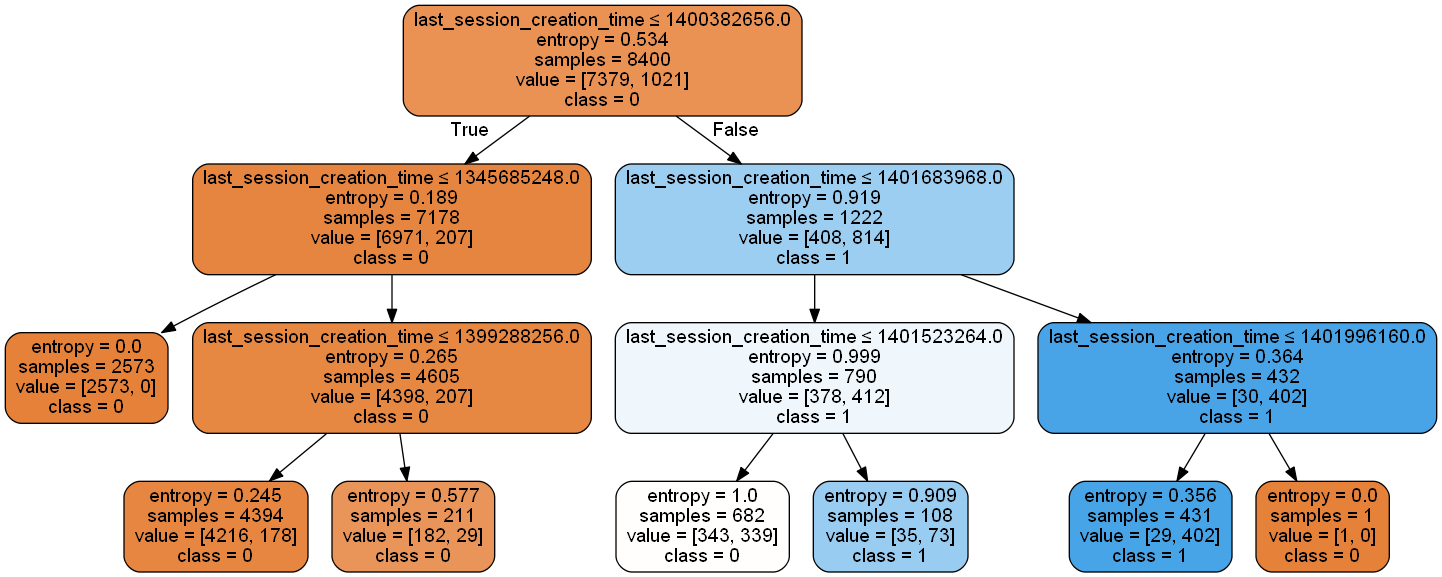

In [27]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = ind_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('adopted.png')
Image(graph.create_png())

In [32]:
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(ind_cols, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
[print('Variable: {:40} Importance: {} '.format(*pair)) for pair in feature_importances]

Variable: last_session_creation_time               Importance: 1.0 
Variable: opted_in_to_mailing_list                 Importance: 0.0 
Variable: enabled_for_marketing_drip               Importance: 0.0 
Variable: org_id                                   Importance: 0.0 
Variable: invited_by_user_id                       Importance: 0.0 
Variable: ORG_INVITE                               Importance: 0.0 
Variable: PERSONAL_PROJECTS                        Importance: 0.0 
Variable: SIGNUP                                   Importance: 0.0 
Variable: SIGNUP_GOOGLE_AUTH                       Importance: 0.0 


[None, None, None, None, None, None, None, None, None]

It appears that the only factor that predicts user adoption is `last_session_creation_time`; the rest of the factors don't seem to matter. To push adoption, Relax Inc. should push more constant usage of their program.

As a side note, logistic regression was tried in this project, but the model was not very accurate, and all the factors had a negative correlation. This just seemed very wrong, so a decision tree was tried instead. A random forest may provide better results as that runs the decision tree algorithm multiple times, increasing the likelihood of getting a better result.